#ECE 1508 Final Project: Text Translation using YouTube Video Transcripts (Group 33)

Team Members with ID: Jiaxiang E(ID: 1005886463), Yixu Ye(ID: 1010506579), Shuqi Yang(ID: 1010198901)

## Library Imports and Project Macros

In [ ]:
!pip install pandas
!pip install torch torchvision
!pip install torchmetrics
!pip install transformers
!pip install nltk rouge
!pip install youtube-transcript-api
!git clone https://github.com/artetxem/vecmap.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 67.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 63.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 96.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [ ]:
#!python3 /content/vecmap/map_embeddings.py --unsupervised /content/SRC.EMB /content/TRG.EMB /content/vecmap/SRC_MAPPED.EMB /content/vecmap/TRG_MAPPED.EMB

In [ ]:
import re
import os
import csv
import nltk
import h5py
import string
import time
import numpy as np
from numpy import array, argmax, random, take
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torch.nn.functional import dropout, relu, softmax, log_softmax
from torch.nn.utils.rnn import pad_sequence
from torch.nn.utils import clip_grad_norm_

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.models import Word2Vec
from gensim.models import KeyedVectors


from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential,Model
from keras.models import load_model
from keras.layers import Input, LSTM, Dense, Embedding,RepeatVector, Bidirectional
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from keras.utils import plot_model

from transformers import BertTokenizer, EncoderDecoderModel, BertModel
from transformers import MarianTokenizer, MarianMTModel

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from youtube_transcript_api import YouTubeTranscriptApi
from youtube_transcript_api._errors import NoTranscriptFound

from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from torchmetrics.text import BLEUScore
from rouge import Rouge
from collections import Counter

nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

## Stage 1: Data Preprocessing

In [ ]:
def merge_transcript_texts(transcript_list):
  # Initialize an empty string to store the merged subtitle text
  merged_text = ''

  # Iterate through the provided list of subtitles
  for item in transcript_list:
  # Extract the 'text' value from each dictionary and append it to the merged_text string
  # A space is used here to separate each subtitle segment for readability
   merged_text += item['text'] + ' '

  # Return the merged subtitle text
  return merged_text.strip()  # Use strip() to remove the trailing space

def load_data(path):
    """
    Load dataset
    """
    input_file = os.path.join(path)
    with open(input_file, "r") as f:
        data = f.read()

    return data.split('\n')

#english_sentences = load_data('/content/small_vocab_en.txt')

#french_sentences = load_data('/content/small_vocab_fr.txt')

In [ ]:
# https://www.youtube.com/watch?v=laod4t3woeU
# video id is the part in watch?v=..... in youtube url
# collect 10 video as the test
# Data fetch and clean

def get_transcript_en_fr(video_id):
  # video_id = 'laod4t3woeU'
  try:
      transcript_list = YouTubeTranscriptApi.list_transcripts(video_id)
      # Fetch the transcript language
      transcript = transcript_list.find_transcript(['en'])
      fr_transcript = transcript_list.find_transcript(['fr'])
      # Fetching the actual transcript data
      transcript_data = transcript.fetch()
      fr_transcript_data = fr_transcript.fetch()

      merged_transcript_data = ''
      fr_merged_transcript_data = ''

      for entry in transcript_data:
        merged_transcript_data += entry['text'] + " "

      for fr_entry in fr_transcript_data:
        fr_merged_transcript_data += fr_entry['text'] + " "

      merged_transcript_data = merged_transcript_data.replace("\n", " ")
      merged_transcript_data = merged_transcript_data.lower()
      fr_merged_transcript_data = fr_merged_transcript_data.replace("\n", " ")
      fr_merged_transcript_data = fr_merged_transcript_data.lower()

      sentences = re.split(r'[.!?] +', merged_transcript_data)
      fr_sentences = re.split(r'[.!?] +', fr_merged_transcript_data)
      print(sentences)
      print(fr_sentences)
      return sentences, fr_sentences

  except Exception as e:
      print(f"An error occurred: {e}")

In [ ]:
video_id_list = ['laod4t3woeU', 'QbzrVpIpSIE', 'D-hLh63iuSI', 'ver3Cg_tMEE', 'D7a7BHaY8-Q','uW9mcG0rdLY','vN_6jfIoYE4','J-uCOLXnzq0','0lo8sAEXPHw','-mEC57qp5fQ']
#video_id_list = ['laod4t3woeU']

all_sentences = []
all_fr_sentences = []
for video_id in video_id_list:
  sentences, fr_sentences = get_transcript_en_fr(video_id)
  print(len(sentences))
  print(len(fr_sentences))
  all_sentences += sentences
  all_fr_sentences += fr_sentences

  with open('en.txt', 'w') as file:
      for item in all_sentences:
          file.write("%s\n" % item)

  with open('fr.txt', 'w') as file:
      for item in all_fr_sentences:
          file.write("%s\n" % item)

filtered_english_sentences = []
filtered_french_sentences = []

for eng, fr in zip(all_sentences, all_fr_sentences):
    if 5 <= len(eng.split()) <= 20 and 5 <= len(fr.split()) <= 20:
        filtered_english_sentences.append(eng)
        filtered_french_sentences.append(fr)
all_sentences = filtered_english_sentences
all_fr_sentences = filtered_french_sentences

train_sentences, temp_sentences, train_fr_sentences, temp_fr_sentences = train_test_split(
    all_sentences, all_fr_sentences, test_size=0.2, random_state=42)

valid_sentences, test_sentences, valid_fr_sentences, test_fr_sentences = train_test_split(
    temp_sentences, temp_fr_sentences, test_size=0.5, random_state=42)  # 0.25 x 0.8 = 0.2

['and laugh at their antics', 'their behavior makes us happy, sad and sometimes scared', 'but do they know emotions', 'do they feel love, fear, sadness and anger', 'until recently it was difficult to study that', 'but thanks to new developments in neuroscience now can', 'for centuries man considered animals as lower life forms', 'a kind of robots that steered by instincts and hormones', 'philosophers believed that as biological machines responded', 'they hardly differed from a table or chair', "they weren't even up to capable of the simplest feelings", 'that prejudice grew into a dogma', "scientists didn't want to be accused of anthropomorphism", 'animal human traits attribute', 'so people were the only thinking beings', 'and animals functioned on their instincts', 'in the past, a scientist this chase like this: zebras experience a stimulus leading to flight behaviour', 'today scientists look open-minded towards animals', 'it is now taken into account that zebras flee out of fear', 'pu

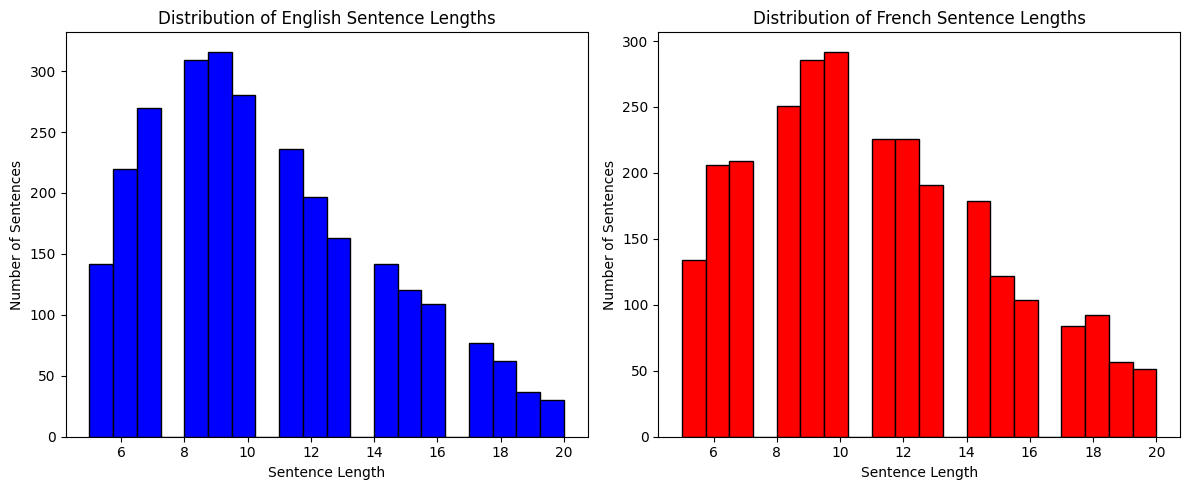

In [ ]:
english_lengths = [len(sentence.split()) for sentence in all_sentences]
french_lengths = [len(sentence.split()) for sentence in all_fr_sentences]


fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(english_lengths, bins=20, color='blue', edgecolor='black')
axes[0].set_title('Distribution of English Sentence Lengths')
axes[0].set_xlabel('Sentence Length')
axes[0].set_ylabel('Number of Sentences')

axes[1].hist(french_lengths, bins=20, color='red', edgecolor='black')
axes[1].set_title('Distribution of French Sentence Lengths')
axes[1].set_xlabel('Sentence Length')
axes[1].set_ylabel('Number of Sentences')

plt.tight_layout()
plt.show()

In [ ]:
def preprocess(sentence):
    # Tokenization and lowercasing
    tokens = sentence.lower().split()
    tokens = [token for token in tokens if token is not None]
    return ' '.join(tokens)

def preprocess_and_tokenize(data):
    data = re.sub(r'[^\w\s]', '', data)
    data = re.sub(r'\s+', ' ', data).strip()
    tokens = word_tokenize(data.lower())
    tokens.append('<EOS>') #or remove
    tokens.insert(0, '<SOS>') #or remove
    return tokens

# padding
def pad(x, length=None):
  return pad_sequences(x, maxlen=length, padding='post')

def logits_to_sentence(logits, tokenizer):
    id_to_word = {id: word for word, id in tokenizer.word_index.items()}
    id_to_word[0] = '<PAD>'
    out = ' '.join(id_to_word[np.argmax(logit)] for logit in logits).replace('<PAD>', '').strip()
    return out

def build_vocab(sentences):
    tokenizer = Tokenizer(filters='')
    tokenizer.fit_on_texts(sentences)
    return tokenizer

def print_vocab(tokenizer):
    word_index = tokenizer.word_index
    for word, index in word_index.items():
        print(f"{word}: {index}")

def prepare_translation_data(english_sentences, french_sentences):

    english_tokens = [preprocess_and_tokenize(sentence) for sentence in english_sentences]
    french_tokens = [preprocess_and_tokenize(sentence) for sentence in french_sentences]

    english_vocab = build_vocab([' '.join(tokens) for tokens in english_tokens])
    french_vocab = build_vocab([' '.join(tokens) for tokens in french_tokens])

    english_sequences = english_vocab.texts_to_sequences([' '.join(tokens) for tokens in english_tokens])
    french_sequences = french_vocab.texts_to_sequences([' '.join(tokens) for tokens in french_tokens])


    max_eng_seq_length = max([len(seq) for seq in english_sequences])
    max_fr_seq_length = max([len(seq) for seq in french_sequences])

    print(f"Max encoder sequence length: {max_eng_seq_length}")
    print(f"Max decoder sequence length: {max_fr_seq_length}")

    return english_tokens, french_tokens, english_vocab, french_vocab, english_sequences, french_sequences, max_eng_seq_length, max_fr_seq_length


english_tokens, french_tokens, english_vocab, french_vocab, english_sequences, french_sequences, max_eng_seq_length, max_fr_seq_length=prepare_translation_data(train_sentences, train_fr_sentences)


padded_tokens_en = pad(english_sequences)
padded_tokens_fr = pad(french_sequences)


print("English vocabulary size:", len(english_vocab.word_index))
print("French vocabulary size:", len(french_vocab.word_index))
print("First English sentence:", sentences[0])
print("First English sentence tokens:", english_sequences[0])
print("First French sentence:", fr_sentences[0])
print("First French sentence tokens:", french_sequences[0])

Max encoder sequence length: 22
Max decoder sequence length: 22
English vocabulary size: 4334
French vocabulary size: 5051
First English sentence: when the winter world disappears, and the sun's rays begin to gather strength, it's the start of a season that is a law unto itself
First English sentence tokens: [1, 867, 1199, 3, 1200, 868, 8, 27, 1926, 5, 869, 1927, 2]
First French sentence: quand le monde hivernal disparaît, et les rayons du soleil commencer à reprendre des forces, c'est le début d'une saison c'est une loi en soi
First French sentence tokens: [1, 15, 687, 8, 1225, 6, 855, 2028, 140, 4, 45, 2029, 9, 2030, 2031, 2]


In [ ]:
training_en_x = pad(padded_tokens_en, padded_tokens_fr.shape[1])
training_en_x_aligned = training_en_x[:len(padded_tokens_fr)]

print(len(training_en_x))
print(len(padded_tokens_fr))

dataset = TensorDataset(torch.from_numpy(training_en_x), torch.from_numpy(padded_tokens_fr))
dataloader = DataLoader(dataset, batch_size=512, shuffle=True)

2168
2168


##Stage 2: Word2Vec

In [ ]:
bleu = BLEUScore()
rouge = Rouge()

vector_size = 100
window = 5
min_count = 1
workers = 4

sg = 1
hs = 0
alpha = 0.025

english_model = Word2Vec(sentences=english_tokens,
                         vector_size=vector_size,
                         window=window,
                         min_count=min_count,
                         workers=workers,
                         sg=sg,
                         hs=hs,
                         alpha=alpha)

french_model = Word2Vec(sentences=french_tokens,
                        vector_size=vector_size,
                        window=window,
                        min_count=min_count,
                        workers=workers,
                        sg=sg,
                        hs=hs,
                        alpha=alpha)

vector = english_model.wv['their']
similarity = english_model.wv.similarity('their', 'end')
similar_words = english_model.wv.most_similar('their', topn=5)
vector, similarity, similar_words

(array([-0.08751848,  0.30268416,  0.00542531,  0.03270154,  0.12512499,
        -0.32911754,  0.04959167,  0.53853065, -0.282716  , -0.1669255 ,
        -0.13572173, -0.25229096, -0.05059835,  0.15138032,  0.08345187,
        -0.19687255,  0.21142393, -0.1408851 , -0.12083092, -0.49435145,
        -0.00581255, -0.08176606,  0.23398879, -0.10200541, -0.01308062,
         0.07546712, -0.14849295, -0.03884495, -0.19111556,  0.05956434,
         0.40835354, -0.03349962, -0.05704095, -0.17692737, -0.19577777,
         0.2371672 ,  0.03800193, -0.10323209,  0.00181056, -0.21642166,
        -0.03720984, -0.25674683, -0.03614819,  0.01671673,  0.3123559 ,
         0.06080888, -0.00669274, -0.13942777, -0.00145726,  0.14621256,
         0.13137214, -0.2104404 , -0.00878654, -0.06698624, -0.11016817,
         0.0068821 ,  0.17253572, -0.05173065, -0.1357699 , -0.03515569,
         0.14081596, -0.0043022 ,  0.14409652,  0.06264356, -0.23802283,
         0.29236937,  0.13801868,  0.27222252, -0.3

In [ ]:
vocab_size_en = len(english_model.wv.key_to_index) + 1
vector_size_en = english_model.vector_size

embedding_matrix_en = np.zeros((vocab_size_en, vector_size_en))

for word, i in english_vocab.word_index.items():
    if word in english_model.wv:
        embedding_vector = english_model.wv[word]
        embedding_matrix_en[i] = embedding_vector

embedding_layer_en = Embedding(input_dim=vector_size_en,
                            output_dim=vector_size,
                            weights=[embedding_matrix_en],
                            trainable=False)

vocab_size_fr = len(french_model.wv.key_to_index) + 1
vector_size_fr = french_model.vector_size

embedding_matrix_fr = np.zeros((vocab_size_fr, vector_size_fr))

for word, i in french_vocab.word_index.items():
    if word in french_model.wv:
        embedding_vector = french_model.wv[word]
        embedding_matrix_fr[i] = embedding_vector

embedding_layer_fr = Embedding(input_dim=vocab_size_fr,
                            output_dim=vector_size_fr,
                            weights=[embedding_matrix_fr],
                            trainable=False)




##Stage 3: Recurrent Neural Network(RNN)

###Utility Toolbox

In [ ]:
def sentence_to_seq(sentence):
    tokens = preprocess_and_tokenize(sentence)
    sequence = [english_vocab.word_index.get(word, english_vocab.word_index.get("<UNK>")) for word in tokens]
    return sequence

def sentence_to_seq_fr(sentence):
    tokens = preprocess_and_tokenize(sentence)
    sequence = [french_vocab.word_index.get(word, french_vocab.word_index.get("<UNK>")) for word in tokens]
    return sequence

def predict_translation(model, sentence, english_tokenizer, french_tokenizer):
    model.eval()
    sequence = sentence_to_seq(sentence)
    sequence = [s for s in sequence if s is not None]
    sequence = pad_sequences([sequence], maxlen=20, padding='post')
    sequence = torch.from_numpy(sequence).to(device)

    with torch.no_grad():
        output = model(sequence)
        output_seq = torch.argmax(output.squeeze(0), dim=1).cpu().numpy()
        output_seq = np.array([a for a, b in zip(output_seq, np.r_[output_seq[1:], output_seq[-1]+1]) if a != b])
        output_seq = output_seq[output_seq != 2]
    translated_sentence = [french_vocab.index_word.get(index, '') for index in output_seq]
    return ' '.join(translated_sentence)

def predict_translation_seq2seq(model, sentence, fr_sentence, english_tokenizer, french_tokenizer):
    model.eval()
    sequence = sentence_to_seq(sentence)
    fr_sequence = sentence_to_seq_fr(fr_sentence)
    sequence = [s for s in sequence if s is not None]
    fr_sequence = [s for s in fr_sequence if s is not None]
    sequence = pad_sequences([sequence], maxlen=20, padding='post')
    fr_sequence = pad_sequences([fr_sequence], maxlen=20, padding='post')
    sequence = torch.from_numpy(sequence).to(device)
    fr_sequence = torch.from_numpy(fr_sequence).to(device)

    with torch.no_grad():
        output = model(sequence, fr_sequence)
        output_seq = torch.argmax(output.squeeze(0), dim=1).cpu().numpy()

    translated_sentence = [french_vocab.index_word.get(index, '') for index in output_seq]
    return ' '.join(translated_sentence)


def model_evaluation_seq2(model, train_sentences, train_fr_sentences, valid_sentences, valid_fr_sentences):
    model.eval()
    total_bleu = 0
    b = 0
    result_train, result_valid = 0, 0
    for test_sentence, test_fr_sentence in zip(train_sentences, train_fr_sentences):
        predicted_french_sentence = predict_translation_seq2seq(model, test_sentence, test_fr_sentence, english_tokens, french_tokens)

        a = sentence_bleu([test_fr_sentence], predicted_french_sentence)
        if a > 0.1:
          total_bleu += a
          b += 1
    if b > 0:
      result_train = total_bleu / b

    total_bleu = 0
    b = 0
    for test_sentence, test_fr_sentence in zip(valid_sentences, valid_fr_sentences):
        english_sentence = test_sentence
        predicted_french_sentence = predict_translation_seq2seq(model, english_sentence, test_fr_sentence, english_tokens, french_tokens)

        a = sentence_bleu([test_fr_sentence], predicted_french_sentence)
        if a > 0.1:
          total_bleu += a
          b += 1
    if b > 0:
      result_valid = total_bleu / b

    return result_train, result_valid



def model_evaluation(model, train_sentences, train_fr_sentences, valid_sentences, valid_fr_sentences):
    model.eval()
    total_bleu = 0
    b = 0
    result_train, result_valid = 0, 0
    for test_sentence, test_fr_sentence in zip(train_sentences, train_fr_sentences):
        english_sentence = test_sentence
        predicted_french_sentence = predict_translation(model, english_sentence, english_tokens, french_tokens)

        a = sentence_bleu([test_fr_sentence], predicted_french_sentence)
        if a > 0.1:
          total_bleu += a
          b += 1
    if b > 0:
      result_train = total_bleu / b

    total_bleu = 0
    b = 0
    for test_sentence, test_fr_sentence in zip(valid_sentences, valid_fr_sentences):
        english_sentence = test_sentence
        predicted_french_sentence = predict_translation(model, english_sentence, english_tokens, french_tokens)

        a = sentence_bleu([test_fr_sentence], predicted_french_sentence)
        if a > 0.1:
          total_bleu += a
          b += 1
    if b > 0:
      result_valid = total_bleu / b

    return result_train, result_valid

def model_plot(epochs, train_losses, train_bleu_scores, valid_bleu_scores):
    epochs_range = range(1, epochs + 1)
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, train_losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Over Time')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, train_bleu_scores, label='Training BLEU Score')
    plt.xlabel('Epochs')
    plt.ylabel('BLEU Score')
    plt.title('Training BLEU Score Over Time')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(epochs_range, valid_bleu_scores, label='Validation BLEU Score')
    plt.xlabel('Epochs')
    plt.ylabel('BLEU Score')
    plt.title('Validation BLEU Score Over Time')
    plt.legend()

    plt.tight_layout()
    plt.show()

def cosine_similarity_sentences(sentence1, sentence2):

    sentence1 = preprocess(sentence1)
    sentence2 = preprocess(sentence2)

    if not sentence1 or not sentence2:
        return 0.0

    vectorizer = CountVectorizer().fit([sentence1, sentence2])
    vectors = vectorizer.transform([sentence1, sentence2]).toarray()
    similarity = cosine_similarity(vectors[0].reshape(1, -1), vectors[1].reshape(1, -1))[0, 0]

    return similarity

def model_similarity_score_seq2(model, test_sentences, test_fr_sentences, english_tokens, french_tokens):
    total_scores = []
    for test_sentence, test_fr_sentence in zip(test_sentences, test_fr_sentences):
      predicted_french_sentence = predict_translation_seq2seq(model, test_sentence, test_fr_sentence, english_tokens, french_tokens)
      #print("*********")
      #print(test_fr_sentence)
      #print(predicted_french_sentence)
      similarity_score= cosine_similarity_sentences(test_fr_sentence, predicted_french_sentence)
      if similarity_score > 0.1:
        total_scores.append(similarity_score)
      #print("Cosine Similarity Score:", similarity_score)
    print("Average Similarity Score {:.10f}".format(float(sum(total_scores) ) / len(total_scores)))


def model_similarity_score(model, test_sentences, test_fr_sentences, english_tokens, french_tokens):
    total_scores = []
    for test_sentence, test_fr_sentence in zip(test_sentences, test_fr_sentences):
      english_sentence = test_sentence
      predicted_french_sentence = predict_translation(model, english_sentence, english_tokens, french_tokens)
      #print("*********")
      #print(test_fr_sentence)
      #print(predicted_french_sentence)
      similarity_score= cosine_similarity_sentences(test_fr_sentence, predicted_french_sentence)
      if similarity_score > 0.1:
        total_scores.append(similarity_score)
      #print("Cosine Similarity Score:", similarity_score)
    print("Average Similarity Score {:.10f}".format(float(sum(total_scores) ) / len(total_scores)))

def prediction_with_translation_scores_seq2(model, test_sentences, test_fr_sentences, english_tokens, french_tokens):
    model.eval()
    rouge = Rouge()
    bleus = []
    meteors = []
    total_rouge = {'rouge-1': 0, 'rouge-2': 0, 'rouge-l': 0}
    rouge_cnt = 0

    for test_sentence, test_fr_sentence in zip(test_sentences, test_fr_sentences):
      predicted_french_sentence = predict_translation_seq2seq(model, test_sentence, test_fr_sentence, english_tokens, french_tokens)

      #print("*********")
      #print(test_fr_sentence)
      #print(predicted_french_sentence)
      if len(predicted_french_sentence) > 0 and len(test_fr_sentence) > 0:
        bleu = sentence_bleu([test_fr_sentence], predicted_french_sentence, smoothing_function=SmoothingFunction().method1)
        if bleu > 0.1:
          bleus.append(bleu)

        reference_tokens = word_tokenize(test_fr_sentence)
        hypothesis_tokens = word_tokenize(predicted_french_sentence)

        meteor = meteor_score([reference_tokens], hypothesis_tokens)
        if meteor > 0.1:
          meteors.append(meteor)

        if len(predicted_french_sentence) > 0 and len(test_fr_sentence[0]) > 0:
          rouge_scores = rouge.get_scores(' '.join(predicted_french_sentence), ' '.join(test_fr_sentence[0]))[0]
          k = False
          for key in total_rouge.keys():
            if rouge_scores[key]['f'] <= 0.1:
              k = True
          if not k:
            for key in total_rouge.keys():
              total_rouge[key] += rouge_scores[key]['f']
            rouge_cnt += 1

    average_bleu_score = sum(bleus) / len(bleus)
    average_meteor_score = sum(meteors) / len(meteors)
    average_rouge_score = {key: score / rouge_cnt for key, score in total_rouge.items() if rouge_cnt != 0}
    print(f"Average BLEU Score: {average_bleu_score:.4f}")
    print(f"Average METEOR Score: {average_meteor_score:.4f}")
    for key in average_rouge_score.keys():
        print(f"Average {key.upper()} Score: {average_rouge_score[key]:.4f}")



def prediction_with_translation_scores(model, test_sentences, test_fr_sentences, english_tokens, french_tokens):
    model.eval()
    rouge = Rouge()
    bleus = []
    meteors = []
    total_rouge = {'rouge-1': 0, 'rouge-2': 0, 'rouge-l': 0}
    rouge_cnt = 0

    for test_sentence, test_fr_sentence in zip(test_sentences, test_fr_sentences):
      english_sentence = test_sentence
      predicted_french_sentence = predict_translation(model, english_sentence, english_tokens, french_tokens)

      #print("*********")
      #print(test_fr_sentence)
      #print(predicted_french_sentence)
      if len(predicted_french_sentence) > 0 and len(test_fr_sentence) > 0:
        bleu = sentence_bleu([test_fr_sentence], predicted_french_sentence, smoothing_function=SmoothingFunction().method1)
        if bleu > 0.1:
          bleus.append(bleu)

        reference_tokens = word_tokenize(test_fr_sentence)
        hypothesis_tokens = word_tokenize(predicted_french_sentence)

        meteor = meteor_score([reference_tokens], hypothesis_tokens)
        if meteor > 0.1:
          meteors.append(meteor)

        if len(predicted_french_sentence) > 0 and len(test_fr_sentence[0]) > 0:
          rouge_scores = rouge.get_scores(' '.join(predicted_french_sentence), ' '.join(test_fr_sentence[0]))[0]
          k = False
          for key in total_rouge.keys():
            if rouge_scores[key]['f'] <= 0.1:
              k = True
          if not k:
            for key in total_rouge.keys():
              total_rouge[key] += rouge_scores[key]['f']
            rouge_cnt += 1

    average_bleu_score = sum(bleus) / len(bleus)
    average_meteor_score = sum(meteors) / len(meteors)
    average_rouge_score = {key: score / rouge_cnt for key, score in total_rouge.items() if rouge_cnt != 0}
    print(f"Average BLEU Score: {average_bleu_score:.4f}")
    print(f"Average METEOR Score: {average_meteor_score:.4f}")
    for key in average_rouge_score.keys():
        print(f"Average {key.upper()} Score: {average_rouge_score[key]:.4f}")

In [ ]:
def train_model(model, dataloader, loss_fn, optimizer, epochs, device):
    model.train(True)
    train_losses = []
    train_bleu_scores = []
    valid_bleu_scores = []
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (input_data, target_data) in enumerate(dataloader):
            model.train(True)
            input_data, target_data = input_data.to(device), target_data.to(device).long()

            output = model(input_data)

            loss = loss_fn(output.view(-1, output.shape[-1]), target_data.view(-1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            train_bleu, valid_bleu = model_evaluation(model, train_sentences, train_fr_sentences, valid_sentences, valid_fr_sentences)
        avg_loss = total_loss / len(dataloader)
        train_losses.append(avg_loss)
        train_bleu_scores.append(train_bleu)
        valid_bleu_scores.append(valid_bleu)
        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss} - Train Bleu: {train_bleu} - Valid Bleu: {valid_bleu}")
    model_plot(epochs, train_losses, train_bleu_scores, valid_bleu_scores)
    print("Training complete.")
    return model, train_losses, train_bleu_scores, valid_bleu_scores

def train_model_seq(model, dataloader, loss_fn, optimizer, epochs, device):
    model.train(True)
    train_losses = []
    train_bleu_scores = []
    valid_bleu_scores = []
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (input_data, target_data) in enumerate(dataloader):
            model.train(True)
            input_data, target_data = input_data.to(device), target_data.to(device).long()

            output = model(input_data, target_data)

            loss = loss_fn(output.view(-1, output.shape[-1]), target_data.view(-1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            train_bleu, valid_bleu = model_evaluation_seq2(model, train_sentences, train_fr_sentences, valid_sentences, valid_fr_sentences)
        avg_loss = total_loss / len(dataloader)
        train_losses.append(avg_loss)
        train_bleu_scores.append(train_bleu)
        valid_bleu_scores.append(valid_bleu)
        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss} - Train Bleu: {train_bleu} - Valid Bleu: {valid_bleu}")
    model_plot(epochs, train_losses, train_bleu_scores, valid_bleu_scores)
    print("Training complete.")
    return model, train_losses, train_bleu_scores, valid_bleu_scores



###VecMap RNN


In [ ]:
english_model.wv.save_word2vec_format("emb_en.EMB", binary=False)
french_model.wv.save_word2vec_format("emb_fr.EMB", binary=False)

In [ ]:
#!python3 /content/vecmap/map_embeddings.py --unsupervised /content/emb_en.EMB /content/emb_fr.EMB /content/en_Mapped.EMB /content/fr_Mapped.EMB
# !python3 /content/vecmap/map_embeddings.py --semi_supervised /content/TRAIN.DICT /content/emb_en.EMB /content/emb_fr.EMB /content/en_Semi.EMB /content/fr_Semi.EMB

# !python3 /content/vecmap/eval_translation.py /content/vecmap/SRC_MAPPED.EMB /content/vecmap/TRG_MAPPED.EMB

In [ ]:
src_embeddings = KeyedVectors.load_word2vec_format('/content/en_Semi.EMB', binary=False)
trg_embeddings = KeyedVectors.load_word2vec_format('/content/fr_Semi.EMB', binary=False)

def translate_word(word, src_embeddings, trg_embeddings):
    if word in src_embeddings:
        word_vec = src_embeddings[word]
        similarities = trg_embeddings.similar_by_vector(word_vec, topn=1)
        translated_word = similarities[0][0]
        return translated_word
    else:
        return "*"

word_to_translate = "rain"
translated_word = translate_word(word_to_translate, src_embeddings, trg_embeddings)
print(f"Translated '{word_to_translate}' to '{translated_word}'.")

Translated 'rain' to 'animal'.


In [ ]:
#!python3 /content/vecmap/eval_translation.py /content/en_Semi.EMB /content/fr_Semi.EMB -d /content/TESTCopy.DICT
#!python3 /content/vecmap/eval_translation.py /content/en_Semi.EMB /content/fr_Semi.EMB -d /content/TEST.DICT

In [ ]:
def load_embeddings_from_file(file_path):
    with open(file_path, 'r') as f:
        # Read the first line to get the size of the embeddings
        first_line = f.readline().strip().split()
        embedding_size = int(first_line[1])

        # Initialize an empty dictionary to hold the embeddings
        embeddings_index = {}
        # Initialize a list to hold all the vectors
        embeddings_vectors = []

        for line in f:
            values = line.strip().split()
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            embeddings_index[word] = len(embeddings_vectors)  # The index of the word is the current length of the list
            embeddings_vectors.append(vector)

        # Create the embedding matrix
        embedding_matrix = np.array(embeddings_vectors)

        return embeddings_index, embedding_matrix

In [ ]:
class vecmyRNN(nn.Module):
    def __init__(self, input_shape, output_sequence_length, english_vocab_size, french_vocab_size, embedding_dim):
        super(vecmyRNN, self).__init__()
        self.input_shape = input_shape
        self.output_sequence_length = output_sequence_length
        self.english_vocab_size = english_vocab_size
        self.french_vocab_size = french_vocab_size

        self.embedding = nn.Embedding(num_embeddings=english_vocab_size + 1, embedding_dim=embedding_dim)

        self.RecUnit = nn.RNN(input_size=embedding_dim, hidden_size=256, batch_first=True)

        self.time_distributed1 = nn.Linear(in_features=256, out_features=1024)

        self.dropout = nn.Dropout(p=0.5)

        self.time_distributed2 = nn.Linear(in_features=1024, out_features=french_vocab_size + 1)



    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.RecUnit(x)
        x = self.time_distributed1(x)
        x = relu(x)
        x = self.dropout(x)
        x = self.time_distributed2(x)
        x = log_softmax(x, dim=2)
        return x

    def compile_model(self, learning_rate):
        self.optimizer = Adam(self.parameters(), lr=learning_rate)
        self.loss_fn = nn.NLLLoss(ignore_index=0)

    def fit(self, x, y, epochs, batch_size):
        for epoch in range(epochs):
            pass

In [ ]:
en_word_index, en_embedding_matrix = load_embeddings_from_file('/content/en_Semi.EMB')
fr_word_index, fr_embedding_matrix = load_embeddings_from_file('/content/fr_Semi.EMB')

In [ ]:
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():  # Updated check for Apple Silicon GPU
    device = "mps"
else:
    device = "cpu"

embedding_dim = en_embedding_matrix.shape[1]

vecmy_model = vecmyRNN(input_shape=training_en_x.shape,
              output_sequence_length=padded_tokens_fr.shape[1],
              english_vocab_size=en_embedding_matrix.shape[0],
              french_vocab_size=fr_embedding_matrix.shape[0],embedding_dim=embedding_dim)


padding_embedding = np.zeros((1, embedding_dim))
en_embedding_matrix_with_padding = np.vstack([padding_embedding, en_embedding_matrix])


vecmy_model.embedding.weight.data.copy_(torch.from_numpy(en_embedding_matrix_with_padding))
vecmy_model.embedding.weight.requires_grad = False

vecmy_model.to(device)

loss_fn = nn.NLLLoss(ignore_index=0)
optimizer = torch.optim.Adam(vecmy_model.parameters(), lr=0.005)

vecmy_model, vecmy_rnn_train_losses, vecmy_rnn_train_bleu_scores, vecmy_rnn_valid_bleu_scores = train_model(vecmy_model, dataloader, loss_fn, optimizer, 100, device)
torch.save(vecmy_model.state_dict(), 'vecmy_model.pth')

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

Epoch 1/100 - Loss: 6.506585569942699 - Train Bleu: 0.12733201557036747 - Valid Bleu: 0
Epoch 2/100 - Loss: 5.8749706745147705 - Train Bleu: 0.12492057381260546 - Valid Bleu: 0.1134080934407007
Epoch 3/100 - Loss: 5.6419783059288475 - Train Bleu: 0.140930095797993 - Valid Bleu: 0.1442023637992043
Epoch 4/100 - Loss: 5.413423117469339 - Train Bleu: 0.16101610254725007 - Valid Bleu: 0.15839885506476636
Epoch 5/100 - Loss: 5.205118880552404 - Train Bleu: 0.17527865036423548 - Valid Bleu: 0.17268050598389667
Epoch 6/100 - Loss: 4.949649362003102 - Train Bleu: 0.1816570565784653 - Valid Bleu: 0.19152011377900915
Epoch 7/100 - Loss: 4.691960152457742 - Train Bleu: 0.18930220259269032 - Valid Bleu: 0.19648162407519787
Epoch 8/100 - Loss: 4.40456839168773 - Train Bleu: 0.2128434846790694 - Valid Bleu: 0.20880981497178872
Epoch 9/100 - Loss: 4.083402472383836 - Train Bleu: 0.2410350885094113 - Valid Bleu: 0.22475718631177372
Epoch 10/100 - Loss: 3.7446668638902554 - Train Bleu: 0.27889866487508

In [ ]:
vecmy_model.eval()
prediction_with_translation_scores(vecmy_model, test_sentences, test_fr_sentences, english_tokens, french_tokens)
model_similarity_score(vecmy_model, test_sentences, test_fr_sentences, english_tokens, french_tokens)

Training complete.
Average BLEU Score: 0.1979
Average METEOR Score: 0.1914
Average Similarity Score 0.3361606633


###Basic RNN

In [ ]:
class myRNN(nn.Module):
    def __init__(self, input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
        super(myRNN, self).__init__()
        self.input_shape = input_shape
        self.output_sequence_length = output_sequence_length
        self.english_vocab_size = english_vocab_size
        self.french_vocab_size = french_vocab_size

        self.embedding = nn.Embedding(num_embeddings=english_vocab_size + 1, embedding_dim=256)

        self.RecUnit = nn.RNN(input_size=256, hidden_size=256, batch_first=True)

        self.time_distributed1 = nn.Linear(in_features=256, out_features=1024)

        self.dropout = nn.Dropout(p=0.5)

        self.time_distributed2 = nn.Linear(in_features=1024, out_features=french_vocab_size + 1)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.RecUnit(x)
        x = self.time_distributed1(x)
        x = relu(x)
        x = self.dropout(x)
        x = self.time_distributed2(x)
        x = log_softmax(x, dim=2)
        return x

    def compile_model(self, learning_rate):
        self.optimizer = Adam(self.parameters(), lr=learning_rate)
        self.loss_fn = nn.NLLLoss(ignore_index=0)

    def fit(self, x, y, epochs, batch_size):
        for epoch in range(epochs):
            pass

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

Epoch 1/100 - Loss: 6.963078880310059 - Train Bleu: 0.15253139444630123 - Valid Bleu: 0.1468345147610751
Epoch 2/100 - Loss: 5.4649632453918455 - Train Bleu: 0.17346561576639624 - Valid Bleu: 0.18390753816300054
Epoch 3/100 - Loss: 4.939350128173828 - Train Bleu: 0.19602908251210435 - Valid Bleu: 0.2072654515308173
Epoch 4/100 - Loss: 4.505986118316651 - Train Bleu: 0.2574679269481639 - Valid Bleu: 0.252343036584479
Epoch 5/100 - Loss: 4.037561750411987 - Train Bleu: 0.30127256761947335 - Valid Bleu: 0.2891325731431262
Epoch 6/100 - Loss: 3.595573902130127 - Train Bleu: 0.34742656188943444 - Valid Bleu: 0.3194139045700791
Epoch 7/100 - Loss: 3.1147483825683593 - Train Bleu: 0.4402074053183661 - Valid Bleu: 0.3407495571623028
Epoch 8/100 - Loss: 2.6371745109558105 - Train Bleu: 0.5485310717984153 - Valid Bleu: 0.3632225020939795
Epoch 9/100 - Loss: 2.255271148681641 - Train Bleu: 0.5783844730271964 - Valid Bleu: 0.3586389846523458
Epoch 10/100 - Loss: 1.9763351202011108 - Train Bleu: 0.

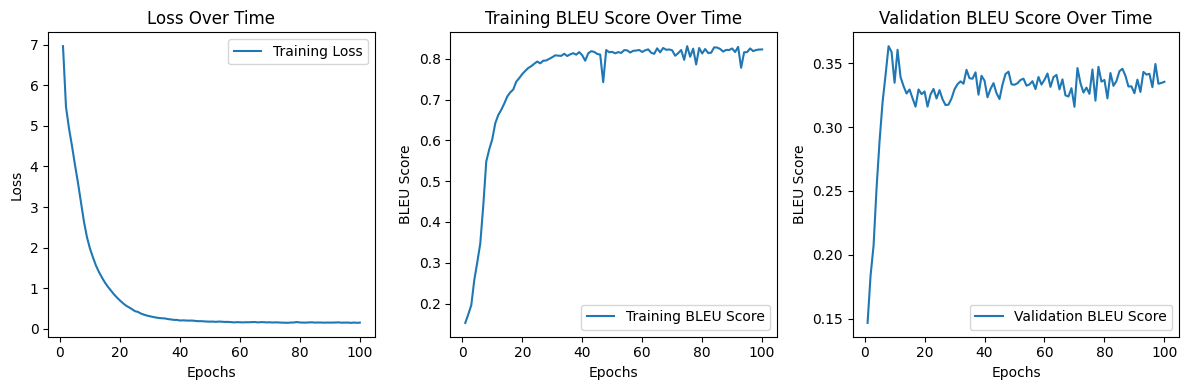

Training complete.


In [ ]:
device = ""
if torch.cuda.is_available():
    device = "cuda"
elif torch.has_mps:
    device = "mps"
else:
    device = "cpu"

basic_rnn_model = myRNN(training_en_x.shape, len(training_en_x), len(english_vocab.word_index), len(french_vocab.word_index))
basic_rnn_model.to(device)

loss_fn = nn.NLLLoss(ignore_index=0)
optimizer = torch.optim.Adam(basic_rnn_model.parameters(), lr=0.005)

train_model(basic_rnn_model, dataloader, loss_fn, optimizer, 100, device)
torch.save(basic_rnn_model.state_dict(), 'basic_rnn_model.pth')

In [ ]:
basic_rnn_model.eval()
prediction_with_translation_scores(basic_rnn_model, test_sentences, test_fr_sentences, english_tokens, french_tokens)
model_similarity_score(basic_rnn_model, test_sentences, test_fr_sentences, english_tokens, french_tokens)

Average BLEU Score: 0.3062
Average METEOR Score: 0.2459
Average Similarity Score 0.3723778787


###GRU RNN

In [ ]:
class GRU_RNN(nn.Module):
    def __init__(self, input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
        super(GRU_RNN, self).__init__()
        self.input_shape = input_shape
        self.output_sequence_length = 512
        self.english_vocab_size = english_vocab_size
        self.french_vocab_size = french_vocab_size

        self.embedding = nn.Embedding(num_embeddings=english_vocab_size + 1, embedding_dim=256)

        self.RecUnit = nn.GRU(input_size=256, hidden_size=256, batch_first=True)

        self.time_distributed1 = nn.Linear(in_features=256, out_features=1024)

        self.dropout = nn.Dropout(p=0.5)

        self.time_distributed2 = nn.Linear(in_features=1024, out_features=french_vocab_size + 1)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.RecUnit(x)
        x = self.time_distributed1(x)
        x = relu(x)
        x = self.dropout(x)
        x = self.time_distributed2(x)
        x = log_softmax(x, dim=2)
        return x

    def compile_model(self, learning_rate):
        self.optimizer = Adam(self.parameters(), lr=learning_rate)
        self.loss_fn = nn.NLLLoss()

    def fit(self, x, y, epochs, batch_size):
        for epoch in range(epochs):
            pass

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

Epoch 1/100 - Loss: 7.409825325012207 - Train Bleu: 0.14002965039367377 - Valid Bleu: 0.1375452989300188
Epoch 2/100 - Loss: 4.629057788848877 - Train Bleu: 0.1434896039989058 - Valid Bleu: 0.13197314531820584
Epoch 3/100 - Loss: 4.020563077926636 - Train Bleu: 0.14938698577871984 - Valid Bleu: 0.12908610939562498
Epoch 4/100 - Loss: 3.8212181091308595 - Train Bleu: 0.14436933313028893 - Valid Bleu: 0.1370234697474099
Epoch 5/100 - Loss: 3.6128392696380613 - Train Bleu: 0.14778783111941787 - Valid Bleu: 0.1401058192059858
Epoch 6/100 - Loss: 3.426584243774414 - Train Bleu: 0.15784274162561762 - Valid Bleu: 0.166903055400894
Epoch 7/100 - Loss: 3.3095991134643556 - Train Bleu: 0.16645644244774355 - Valid Bleu: 0.17843272142614966
Epoch 8/100 - Loss: 3.186945009231567 - Train Bleu: 0.17364373145543327 - Valid Bleu: 0.17668899699530727
Epoch 9/100 - Loss: 3.095674991607666 - Train Bleu: 0.17414998363463163 - Valid Bleu: 0.19244717864424404
Epoch 10/100 - Loss: 3.011181354522705 - Train Bl

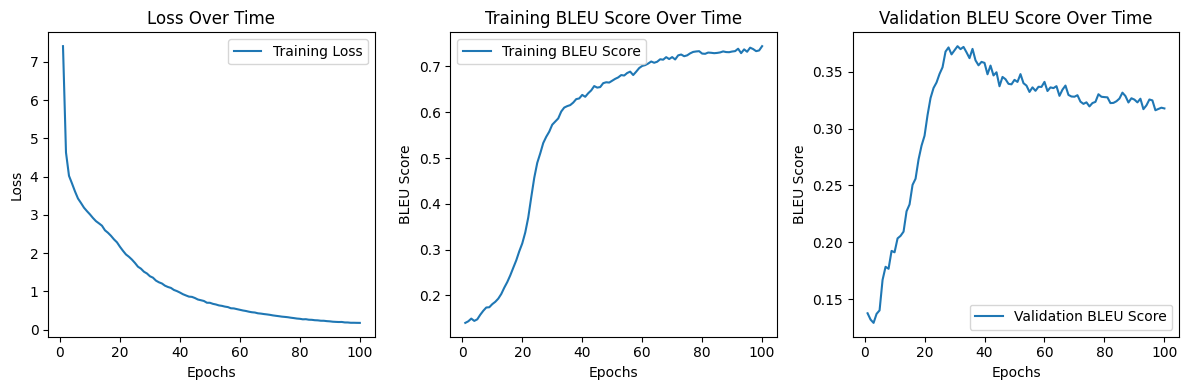

Training complete.


In [ ]:
gru_rnn_model = GRU_RNN(training_en_x.shape, len(training_en_x), len(english_vocab.word_index), len(french_vocab.word_index))
gru_rnn_model.to(device)
loss_fn = nn.NLLLoss()
optimizer = torch.optim.Adam(gru_rnn_model.parameters(), lr=0.001)
train_model(gru_rnn_model, dataloader, loss_fn, optimizer, 100, device)
torch.save(gru_rnn_model.state_dict(), 'gru_rnn_model.pth')

In [ ]:
gru_rnn_model.eval()
prediction_with_translation_scores(gru_rnn_model, test_sentences, test_fr_sentences, english_tokens, french_tokens)
model_similarity_score(gru_rnn_model, test_sentences, test_fr_sentences, english_tokens, french_tokens)

Average BLEU Score: 0.3109
Average METEOR Score: 0.2299
Average Similarity Score 0.3645935308


###LSTM RNN

In [ ]:
class LSTM_RNN(nn.Module):
    def __init__(self, input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
        super(LSTM_RNN, self).__init__()
        self.input_shape = input_shape
        self.output_sequence_length = output_sequence_length
        self.english_vocab_size = english_vocab_size
        self.french_vocab_size = french_vocab_size

        # Embedding layer remains the same
        self.embedding = nn.Embedding(num_embeddings=english_vocab_size + 1, embedding_dim=input_shape[1])

        # Replace nn.RNN with nn.LSTM
        self.RecUnit = self.RecUnit = nn.LSTM(input_size=input_shape[1], hidden_size=output_sequence_length, batch_first=True)

        # Other layers remain unchanged
        self.time_distributed1 = nn.Linear(in_features=output_sequence_length, out_features=1024)
        self.dropout = nn.Dropout(p= 0.5)
        self.time_distributed2 = nn.Linear(in_features=1024, out_features=french_vocab_size + 1)

    def initial_state(self):
        hidden_state = torch.zeros(1, input_shape[1], output_sequence_length)
        cell_state = torch.zeros(1, input_shape[1], output_sequence_length)
        return hidden_state, cell_state

    def forward(self, x):
        x = self.embedding(x)  # Embedding step is unchanged
        x, (hidden, cell) = self.RecUnit(x)  # LSTM returns hidden and cell states
        x = self.time_distributed1(x)
        x = relu(x)
        x = self.dropout(x)
        x = self.time_distributed2(x)
        x = log_softmax(x, dim=2)
        return x


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

Epoch 1/100 - Loss: 7.111778259277344 - Train Bleu: 0.1309669185579015 - Valid Bleu: 0.14075101270041393
Epoch 2/100 - Loss: 5.182790946960449 - Train Bleu: 0 - Valid Bleu: 0
Epoch 3/100 - Loss: 4.614091205596924 - Train Bleu: 0 - Valid Bleu: 0
Epoch 4/100 - Loss: 4.148055982589722 - Train Bleu: 0 - Valid Bleu: 0
Epoch 5/100 - Loss: 3.8610625743865965 - Train Bleu: 0.12761022543572334 - Valid Bleu: 0.11002768759157971
Epoch 6/100 - Loss: 3.710537052154541 - Train Bleu: 0.12857009799614005 - Valid Bleu: 0.13048755855628041
Epoch 7/100 - Loss: 3.6724894523620604 - Train Bleu: 0.13186834313413137 - Valid Bleu: 0.10887799865524354
Epoch 8/100 - Loss: 3.626306438446045 - Train Bleu: 0.13950347788733475 - Valid Bleu: 0.11174800908757791
Epoch 9/100 - Loss: 3.5454344749450684 - Train Bleu: 0.13394465740019085 - Valid Bleu: 0.12202183600391417
Epoch 10/100 - Loss: 3.551199531555176 - Train Bleu: 0.13577665952019502 - Valid Bleu: 0.11892599512979238
Epoch 11/100 - Loss: 3.5399508476257324 - Tra

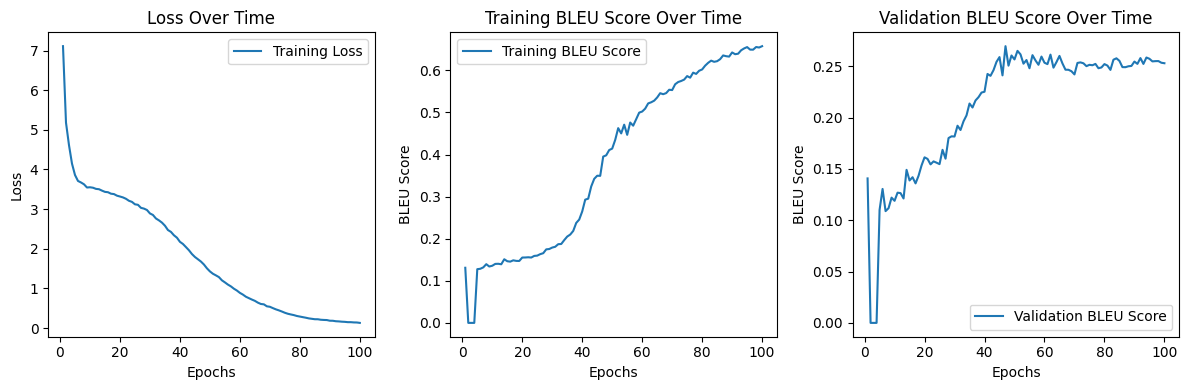

Training complete.


In [ ]:
lstm_rnn_model = LSTM_RNN(training_en_x.shape, len(training_en_x), len(english_vocab.word_index), len(french_vocab.word_index))
lstm_rnn_model.to(device)
loss_fn = nn.NLLLoss()
optimizer = torch.optim.Adam(lstm_rnn_model.parameters(), lr=0.001)
train_model(lstm_rnn_model, dataloader, loss_fn, optimizer, 100, device)
torch.save(lstm_rnn_model.state_dict(), 'lstm_rnn_model.pth')

In [ ]:
lstm_rnn_model.eval()
prediction_with_translation_scores(lstm_rnn_model, test_sentences, test_fr_sentences, english_tokens, french_tokens)
model_similarity_score(lstm_rnn_model, test_sentences, test_fr_sentences, english_tokens, french_tokens)

Average BLEU Score: 0.2378
Average METEOR Score: 0.2074
Average Similarity Score 0.3327654431


### Seq2GRU RNN

In [ ]:
class GRUSeq2Seq(nn.Module):
    def __init__(self, input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
        super(GRUSeq2Seq, self).__init__()
        self.input_shape = input_shape
        embedding_dim = 256  # Define embedding dimension
        hidden_dim = output_sequence_length  # Define hidden dimension
        dropout_rate = 0.5  # Dropout rate
        # Encoder
        self.encoder_embedding = nn.Embedding(english_vocab_size + 1, embedding_dim)
        self.encoder_gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)

        # Decoder
        self.decoder_embedding = nn.Embedding(french_vocab_size + 1, embedding_dim)
        self.decoder_gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)

        self.time_distributed1 = nn.Linear(in_features=hidden_dim, out_features=1024)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.time_distributed2 = nn.Linear(in_features=1024, out_features=french_vocab_size + 1)

    def forward(self, src, trg):
        # Encoding
        embedded_src = self.dropout(self.encoder_embedding(src))
        _, hidden = self.encoder_gru(embedded_src)  # Context vector

        embedded_trg = self.dropout(self.decoder_embedding(trg))
        decoder_outputs, _ = self.decoder_gru(embedded_trg, hidden)
        decoder_outputs = relu(decoder_outputs)
        decoder_outputs = self.time_distributed1(decoder_outputs)
        decoder_outputs = relu(decoder_outputs)
        decoder_outputs = self.dropout(decoder_outputs)
        decoder_outputs = self.time_distributed2(decoder_outputs)
        decoder_outputs = log_softmax(decoder_outputs, dim=2)
        return decoder_outputs

    def compile_model(self, learning_rate):
        self.optimizer = Adam(self.parameters(), lr=learning_rate)
        self.loss_fn = nn.NLLLoss()

    def fit(self, src, trg, epochs, batch_size):
        pass

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

Epoch 1/100 - Loss: 6.892790603637695 - Train Bleu: 0 - Valid Bleu: 0
Epoch 2/100 - Loss: 3.7870351791381838 - Train Bleu: 0.13783995838621188 - Valid Bleu: 0.13365797713296962
Epoch 3/100 - Loss: 3.2613686084747315 - Train Bleu: 0.15559774781491978 - Valid Bleu: 0.14392831120291721
Epoch 4/100 - Loss: 3.05837721824646 - Train Bleu: 0.1832651526804329 - Valid Bleu: 0.17582185473927361
Epoch 5/100 - Loss: 2.863051748275757 - Train Bleu: 0.23251910703875908 - Valid Bleu: 0.22156791692509756
Epoch 6/100 - Loss: 2.669681692123413 - Train Bleu: 0.2451083682601643 - Valid Bleu: 0.22719844300223077
Epoch 7/100 - Loss: 2.514278268814087 - Train Bleu: 0.2612341394314601 - Valid Bleu: 0.2422330512679909
Epoch 8/100 - Loss: 2.354680824279785 - Train Bleu: 0.29243582495728143 - Valid Bleu: 0.2736509257830069
Epoch 9/100 - Loss: 2.2390450477600097 - Train Bleu: 0.3172221950586314 - Valid Bleu: 0.2907423030283729
Epoch 10/100 - Loss: 2.14620156288147 - Train Bleu: 0.3409993205690554 - Valid Bleu: 0.

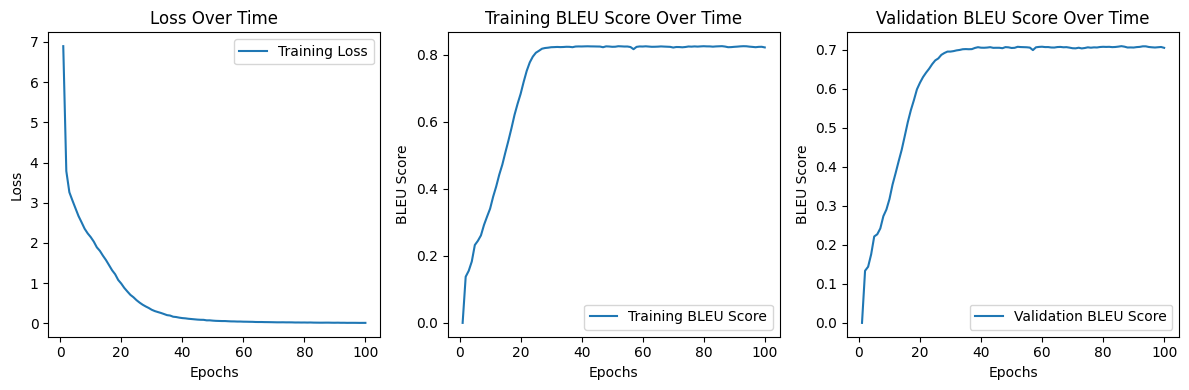

Training complete.


In [ ]:
gru_seq2seq_model = GRUSeq2Seq(training_en_x.shape, len(training_en_x), len(english_vocab.word_index), len(french_vocab.word_index))
gru_seq2seq_model.to(device)
loss_fn = nn.NLLLoss()
optimizer = torch.optim.Adam(gru_seq2seq_model.parameters(), lr=0.001)
train_model_seq(gru_seq2seq_model, dataloader, loss_fn, optimizer, 100, device)
#train_model(gru_seq2seq_model, dataloader, loss_fn, optimizer, 100, device)
torch.save(gru_seq2seq_model.state_dict(), 'gru_seq2seq_model.pth')

In [ ]:
gru_seq2seq_model.eval()
prediction_with_translation_scores_seq2(gru_seq2seq_model, test_sentences, test_fr_sentences, english_tokens, french_tokens)
model_similarity_score_seq2(gru_seq2seq_model, test_sentences, test_fr_sentences, english_tokens, french_tokens)

Average BLEU Score: 0.7041
Average METEOR Score: 0.7746
Average Similarity Score 0.8693810323


###Seq2LSTM RNN

In [ ]:
class LSTMSeq2Seq(nn.Module):
    def __init__(self, input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
        super(LSTMSeq2Seq, self).__init__()
        self.input_shape = input_shape
        embedding_dim = 256  # Define embedding dimension
        hidden_dim = output_sequence_length  # Define hidden dimension
        dropout_rate = 0.5  # Dropout rate
        # Encoder
        self.encoder_embedding = nn.Embedding(english_vocab_size + 1, embedding_dim)
        self.encoder_lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)

        # Decoder
        self.decoder_embedding = nn.Embedding(french_vocab_size + 1, embedding_dim)
        self.decoder_lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)

        self.time_distributed1 = nn.Linear(in_features=hidden_dim, out_features=1024)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.time_distributed2 = nn.Linear(in_features=1024, out_features=french_vocab_size + 1)

    def forward(self, src, trg):
        # Encoding
        embedded_src = self.dropout(self.encoder_embedding(src))
        _, hidden = self.encoder_lstm(embedded_src)  # Context vector

        embedded_trg = self.dropout(self.decoder_embedding(trg))
        decoder_outputs, _ = self.decoder_lstm(embedded_trg, hidden)
        decoder_outputs = relu(decoder_outputs)
        decoder_outputs = self.time_distributed1(decoder_outputs)
        decoder_outputs = relu(decoder_outputs)
        decoder_outputs = self.dropout(decoder_outputs)
        decoder_outputs = self.time_distributed2(decoder_outputs)
        decoder_outputs = log_softmax(decoder_outputs, dim=2)
        return decoder_outputs

    def compile_model(self, learning_rate):
        self.optimizer = Adam(self.parameters(), lr=learning_rate)
        self.loss_fn = nn.NLLLoss()

    def fit(self, src, trg, epochs, batch_size):
        pass

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

Epoch 1/100 - Loss: 7.1398214340209964 - Train Bleu: 0 - Valid Bleu: 0
Epoch 2/100 - Loss: 4.448167419433593 - Train Bleu: 0.10351976784352601 - Valid Bleu: 0.10880718951222419
Epoch 3/100 - Loss: 3.5260751724243162 - Train Bleu: 0.12009381037378905 - Valid Bleu: 0.12290413406522932
Epoch 4/100 - Loss: 3.304367685317993 - Train Bleu: 0.1445965570669581 - Valid Bleu: 0.14347183260640547
Epoch 5/100 - Loss: 3.141363334655762 - Train Bleu: 0.14260956848684117 - Valid Bleu: 0.13511050690066134
Epoch 6/100 - Loss: 3.0421518802642824 - Train Bleu: 0.1605121848321196 - Valid Bleu: 0.16019195954968585
Epoch 7/100 - Loss: 2.9247052669525146 - Train Bleu: 0.1791961844773844 - Valid Bleu: 0.17668558801756254
Epoch 8/100 - Loss: 2.7972870826721192 - Train Bleu: 0.21803392017003387 - Valid Bleu: 0.20666718971522582
Epoch 9/100 - Loss: 2.654458522796631 - Train Bleu: 0.23068411860817506 - Valid Bleu: 0.21497128199943213
Epoch 10/100 - Loss: 2.516125202178955 - Train Bleu: 0.23647665323553327 - Valid

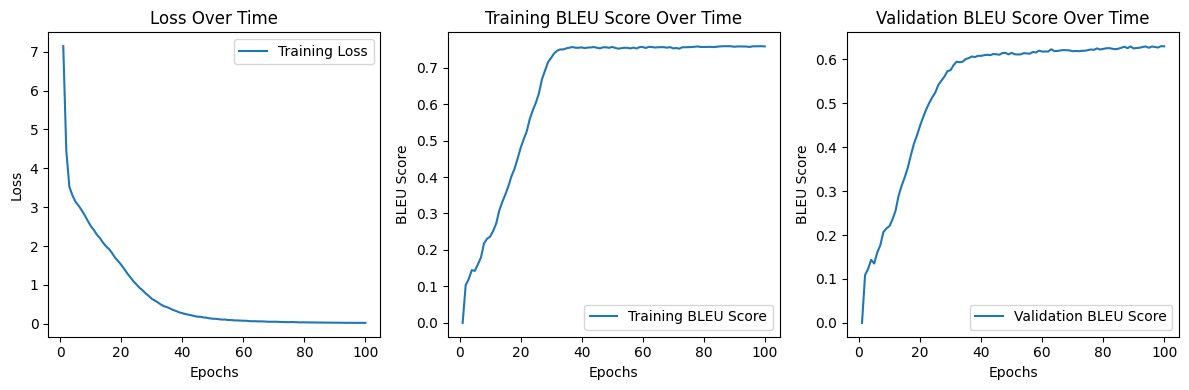

Training complete.


In [ ]:
lstm_seq2seq_model = LSTMSeq2Seq(training_en_x.shape, len(training_en_x), len(english_vocab.word_index), len(french_vocab.word_index))
lstm_seq2seq_model.to(device)
loss_fn = nn.NLLLoss()
optimizer = torch.optim.Adam(lstm_seq2seq_model.parameters(), lr=0.001)
train_model_seq(lstm_seq2seq_model, dataloader, loss_fn, optimizer, 100, device)
torch.save(lstm_seq2seq_model.state_dict(), 'lstm_seq2seq_model.pth')

In [ ]:
lstm_seq2seq_model.eval()
prediction_with_translation_scores_seq2(lstm_seq2seq_model, test_sentences, test_fr_sentences, english_tokens, french_tokens)
model_similarity_score_seq2(lstm_seq2seq_model, test_sentences, test_fr_sentences, english_tokens, french_tokens)

Average BLEU Score: 0.6368
Average METEOR Score: 0.6646
Average Similarity Score 0.7627351009


##Stage 4: Seq2Seq Transformer


In [ ]:
model_name = "Helsinki-NLP/opus-mt-en-fr"

tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:197: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [ ]:
encoded_inputs_en = tokenizer(all_sentences, padding='longest', truncation=True, return_tensors="pt")
encoded_inputs_fr = tokenizer(all_fr_sentences, padding='longest', truncation=True, return_tensors="pt")

input_ids_en = encoded_inputs_en['input_ids']
attention_masks_en = encoded_inputs_en['attention_mask']
input_ids_fr = encoded_inputs_fr['input_ids']
attention_masks_fr = encoded_inputs_fr['attention_mask']

max_length = max(input_ids_en.shape[1], input_ids_fr.shape[1])

input_ids_en = torch.nn.functional.pad(input_ids_en, (0, max_length - input_ids_en.shape[1]), value=tokenizer.pad_token_id)
attention_masks_en = torch.nn.functional.pad(attention_masks_en, (0, max_length - attention_masks_en.shape[1]), value=0)
input_ids_fr = torch.nn.functional.pad(input_ids_fr, (0, max_length - input_ids_fr.shape[1]), value=tokenizer.pad_token_id)
attention_masks_fr = torch.nn.functional.pad(attention_masks_fr, (0, max_length - attention_masks_fr.shape[1]), value=0)

dataset = TensorDataset(input_ids_en, attention_masks_en, input_ids_fr, attention_masks_fr)
len(input_ids_en), len(input_ids_fr)

(2710, 2710)

In [ ]:
device = ""
if torch.cuda.is_available():
  device = "cuda"
elif torch.has_mps:
  device = "mps"
else:
  device = "cpu"

In [ ]:
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

num_epochs = 5
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.95)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in dataloader:
        input_ids_en, attention_mask_en, input_ids_fr, attention_mask_fr = [b.to(device) for b in batch]

        decoder_input_ids = torch.cat([
          torch.full((input_ids_fr.shape[0], 1), model.config.decoder_start_token_id, dtype=torch.long, device=device),
          input_ids_fr[:, :-1]], dim=-1)


        labels = input_ids_fr[:, 1:].contiguous()
        labels[input_ids_fr[:, 1:] == model.config.pad_token_id] = -100

        if labels.shape[1] < decoder_input_ids.shape[1]:
          padding = torch.full((labels.shape[0], 1), -100, dtype=torch.long, device=device)
          labels = torch.cat([labels, padding], dim=-1)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids_en, attention_mask=attention_mask_en, decoder_input_ids=decoder_input_ids, decoder_attention_mask=attention_mask_fr, labels=labels)

        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch + 1}/{num_epochs} loss: {avg_loss}")

model.save_pretrained("./transformer_translation_model")
tokenizer.save_pretrained("./transformer_translation_model")

Epoch 1/5 loss: 5.4768588262445785
Epoch 2/5 loss: 4.231263877363766
Epoch 3/5 loss: 3.6765875858419084
Epoch 4/5 loss: 3.2851618570439958


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[59513]], 'forced_eos_token_id': 0}


Epoch 5/5 loss: 2.9677009540445662


('./transformer_translation_model/tokenizer_config.json',
 './transformer_translation_model/special_tokens_map.json',
 './transformer_translation_model/vocab.json',
 './transformer_translation_model/source.spm',
 './transformer_translation_model/target.spm',
 './transformer_translation_model/added_tokens.json')

In [ ]:
tmp_test_sentences = []
tmp_test_fr_sentences = []
for i in range(31, 50):
    tmp_test_sentences.append(test_sentences[i])
    tmp_test_fr_sentences.append(test_fr_sentences[i])
test_sentences = tmp_test_sentences
test_fr_sentences = tmp_test_fr_sentences

In [ ]:
test_inputs = tokenizer(test_sentences, padding=True, truncation=True, return_tensors="pt")

test_input_ids = test_inputs['input_ids'].to(device)
test_attention_mask = test_inputs['attention_mask'].to(device)

model.config.decoder_start_token_id = 101

model.eval()

with torch.no_grad():
    predicted_ids = model.generate(input_ids=test_input_ids, attention_mask=test_attention_mask)

predicted_sentences_fr = [tokenizer.decode(generated_id_seq, skip_special_tokens=True) for generated_id_seq in predicted_ids]

total_bleu = []
total_meteor = []
#total_rouge = {'precision': 0, 'recall': 0, 'f': 0}

rouge = Rouge()
for sentence, sentence_fr in zip(test_fr_sentences, predicted_sentences_fr):
    print("Correct French:", sentence)
    print("Predicted French Translation:", sentence_fr)
    print("*********")

    a = sentence_bleu([sentence], sentence_fr)
    if a > 0.1:
      total_bleu.append(a)

    reference_tokens = word_tokenize(sentence)
    hypothesis_tokens = word_tokenize(sentence_fr)
    b = meteor_score([reference_tokens], hypothesis_tokens)
    if b > 0.1:
      total_meteor.append(b)
    #rouge_scores = rouge.get_scores(' '.join(sentence), ' '.join(sentence_fr[0]))[0]
    #for key in total_rouge.keys():
    #    total_rouge[key] += rouge_scores[key]['f']

average_bleu_score = sum(total_bleu) / len(total_bleu)
average_meteor_score = sum(total_meteor) / len(total_meteor)
    #average_rouge_score = {key: score / len(test_sentences) for key, score in total_rouge.items()}
print(f"Average BLEU Score: {average_bleu_score:.4f}")
print(f"Average METEOR Score: {average_meteor_score:.4f}")
    #for key in average_rouge_score.keys():
    #    print(f"Average {key.upper()} Score: {average_rouge_score[key]:.4f}")

Correct French: certains d'entre eux veulent juste jouer
Predicted French Translation: lun d'euxuteu  deir
*********
Correct French: oui, ça arrive souvent, la première fois que c'est arrivé, ça m'a fait cette grosse coupure au bras
Predicted French Translation: y,ça arrivecoquequeque chose arrive laièreis' cestv,ça ma don c grand coup monar
*********
Correct French: le martin-pêcheur a été créatif et a fait son nid dans la masse racinaire enchevêtrée d'un arbre renversé
Predicted French Translation: marche pche aétéréif et fa son dans dans ma ra é é é éée m en ra ra d'bre tolé
*********
Correct French: il fouille assidûment sur le sol de la forêt, ce qui révèle pas mal de bousiers
Predicted French Translation: ' rueitement sur lel de fort qui v unauaussausseurs
*********
Correct French: une procédure longue et ardue pour seulement quelques jours de vol
Predicted French Translation: proce de long et ause poureu que quequesjour deer
*********
Correct French: la fête est finie et c'est r

In [ ]:
for i in range(min(10, len(test_sentences))):
    print("*********\n")
    print(f"Test English: {test_sentences[i]}")
    print(f"Test French: {test_fr_sentences[i]}\n")
    print(f"French Predicted: {predicted_sentences_fr[i]}\n")

*********

Test English: ensuring future generations and getting the world to bloom again
Test French: assurer les générations futures et faire refleurir le monde

French Predicted: assure lesénération future etmetdre mon àpan àuv

*********

Test English: the steady water is also a paradise for dragonflies
Test French: l'eau stable est aussi un paradis pour les libellules

French Predicted: ' stable estussi para pour liules

*********

Test English: young macaques can't do anything at birth
Test French: les jeunes macaques ne peuvent rien faire à la naissance

French Predicted: jesca neeu pa ne fa à ri à lanaisation

*********

Test English: studies rats to see what what happens in their brains with fear
Test French: étudie les rats pour voir ce ce qui se passe dans leur cerveau avec peur

French Predicted: édie rat pourvoir  ce quie dansleurrv aveceur

*********

Test English: if you're up for adopting must be able to recognize..
Test French: si vous êtes partant pour adopter faut sa